This notebook focuses on utilizing the functionalities to analyze the magnetic sensor data. The main methods used here are sourced from the group_magnetic_sensor_data.py package. This part of the code import the neceesary packages to analyze the mangetic data:

In [23]:
# --- external imports ---
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
# --- local imports ---
from group_magnetic_sensor_data import *

The next part loops through different groups of the magnetic current data and:
- matches the timestamps
- finds the mean ratio of mag/current for all timestamps
- extracts the picks of both current and magnetic signal and finds the mean ratio
- solves for an estimate of gain, skewness and mean squared errors as well as the mean absolute errors and the inlier ratio of the estimates
- compares the sample times of peaks in the actual timestamps and extracts the delays between the peaks of the magnetic and current signal for each coil
- extracts the frequency response of the sensor based on the fft(mag)/fft(current)

In [24]:
data_file_path="./signal_processing_dataset.hdf5"
data_file_h5_object=h5py.File(data_file_path,'r')

save_coefficient_all_times=[]
save_coefficient_peak_times=[]
save_gain_skewness=[]
save_time_delay=np.zeros((1,2))
save_frequency_response_data=[]

for group_key in list(data_file_h5_object.keys()):
    print(group_key)
    group_data=data_file_h5_object[group_key]
    frequency_amplitude_data=GroupMagneticSensorData(group_data)

    corresponding_current_magnetic_data=frequency_amplitude_data.match_current_mag()
    mag_current_coefficients_all_timestamps=frequency_amplitude_data.check_proportional(corresponding_current_magnetic_data)
    save_coefficient_all_times.append({"coil":frequency_amplitude_data.axis
                              ,"frequency":frequency_amplitude_data.frequency
                              ,"coefficient":np.mean(abs(mag_current_coefficients_all_timestamps[:,frequency_amplitude_data.axis]),axis=0)})

    peaks_indices_current=frequency_amplitude_data.find_peak_indices_signal("Current")
    peaks_indices_mag=frequency_amplitude_data.find_peak_indices_signal("Mag")
    gain_from_peaks, saved_peak_records=frequency_amplitude_data.find_gain_peaks(peak_current_indices=peaks_indices_current,peak_magnetic_indices=peaks_indices_mag)
    save_coefficient_peak_times.append({"coil":frequency_amplitude_data.axis
                              ,"frequency":frequency_amplitude_data.frequency
                              ,"coefficient":np.mean(abs(gain_from_peaks[:,frequency_amplitude_data.axis]),axis=0)})


    estimated_gain, estimated_skewness, mse, mae, inlier_ratio=frequency_amplitude_data.estimate_gain_and_skewness_from_peaks(
        saved_peaks_magnetic_current=saved_peak_records)
    save_gain_skewness.append({"coil":frequency_amplitude_data.axis,"frequency":frequency_amplitude_data.frequency
                               ,"estimated_gain":estimated_gain,"estimated_skewness":estimated_skewness
                               ,"mean_squared_error":mse,"mean_absolute_error":mae,"inlier_ratio":inlier_ratio})
    
    timestamp_delays=frequency_amplitude_data.compare_sample_times(peaks_indices_current,peaks_indices_mag)
    save_time_delay=np.vstack((save_time_delay,timestamp_delays))


    frequency_response_data=frequency_amplitude_data.frequency_response()
    save_frequency_response_data.append(frequency_response_data)
    



Coil_X_Freq100_Amp10
Coil_X_Freq100_Amp30
Coil_X_Freq100_Amp50
Coil_X_Freq100_Amp70
Coil_X_Freq100_Amp90
Coil_X_Freq10_Amp10
Coil_X_Freq10_Amp30
Coil_X_Freq10_Amp50
Coil_X_Freq10_Amp70
Coil_X_Freq10_Amp90
Coil_X_Freq42_Amp10
Coil_X_Freq42_Amp30
Coil_X_Freq42_Amp50
Coil_X_Freq42_Amp70
Coil_X_Freq42_Amp90
Coil_X_Freq74_Amp10
Coil_X_Freq74_Amp30
Coil_X_Freq74_Amp50
Coil_X_Freq74_Amp70
Coil_X_Freq74_Amp90
Coil_Y_Freq100_Amp10
Coil_Y_Freq100_Amp30
Coil_Y_Freq100_Amp50
Coil_Y_Freq100_Amp70
Coil_Y_Freq100_Amp90
Coil_Y_Freq10_Amp10
Coil_Y_Freq10_Amp30
Coil_Y_Freq10_Amp50
Coil_Y_Freq10_Amp70
Coil_Y_Freq10_Amp90
Coil_Y_Freq42_Amp10
Coil_Y_Freq42_Amp30
Coil_Y_Freq42_Amp50
Coil_Y_Freq42_Amp70
Coil_Y_Freq42_Amp90
Coil_Y_Freq74_Amp10
Coil_Y_Freq74_Amp30
Coil_Y_Freq74_Amp50
Coil_Y_Freq74_Amp70
Coil_Y_Freq74_Amp90
Coil_Z_Freq100_Amp10
Coil_Z_Freq100_Amp30
Coil_Z_Freq100_Amp50
Coil_Z_Freq100_Amp70
Coil_Z_Freq100_Amp90
Coil_Z_Freq10_Amp10
Coil_Z_Freq10_Amp30
Coil_Z_Freq10_Amp50
Coil_Z_Freq10_Amp70
Coil_

This part saves the mean ratios of mag/current from all timestamps and plots it for each activated coil

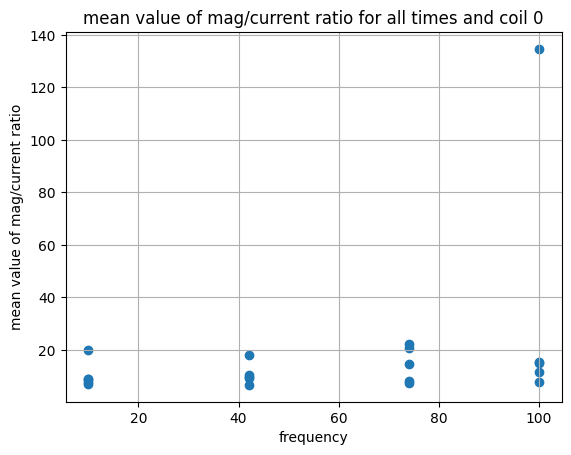

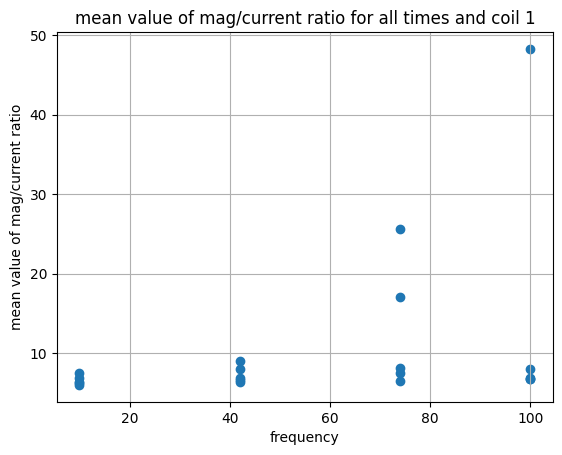

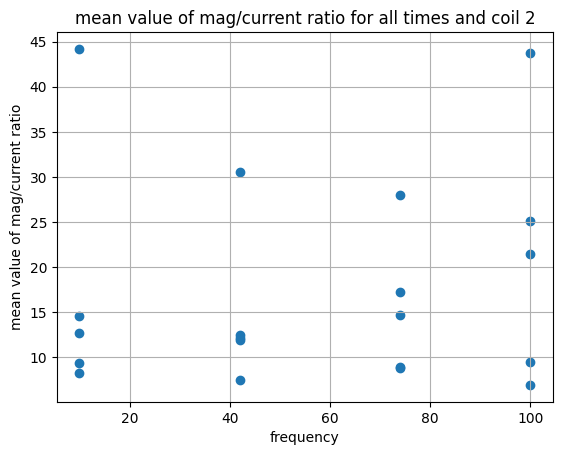

In [26]:
dataframe_mag_current_coefficients_all_timestamps=pd.DataFrame(save_coefficient_all_times)
for coil_index in range(3):
    condition=dataframe_mag_current_coefficients_all_timestamps["coil"]==coil_index
    filtered_dataframe=dataframe_mag_current_coefficients_all_timestamps[condition]
    plt.figure()
    plt.scatter(filtered_dataframe["frequency"],filtered_dataframe["coefficient"])
    plt.xlabel("frequency")
    plt.ylabel("mean value of mag/current ratio")
    plt.title("mean value of mag/current ratio for all times and coil "+str(coil_index))
    plt.grid(True)
plt.show()

The next plots show the spread of the mag/current signal from only peaks at each cycle which is then averaged for each activated coil:

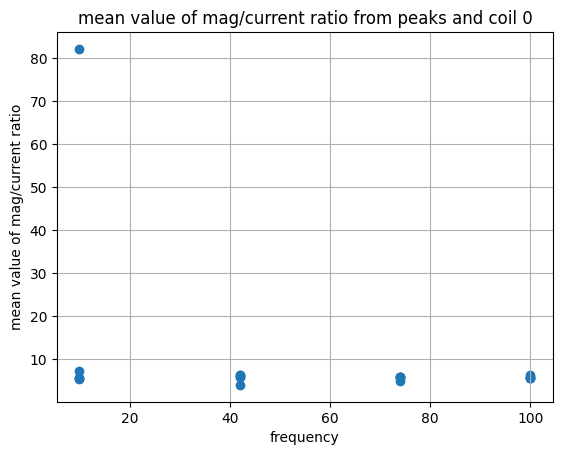

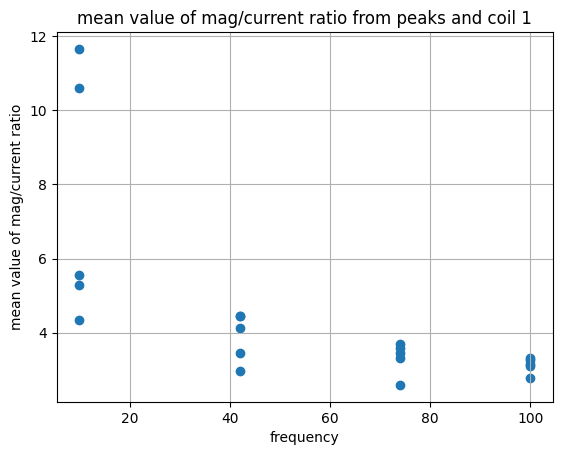

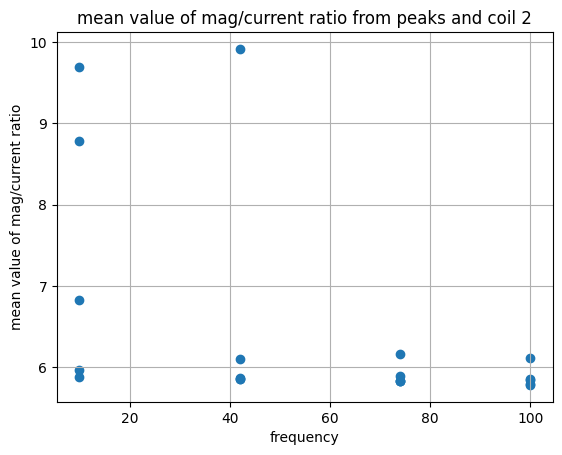

In [27]:
dataframe_coefficient_peak_times=pd.DataFrame(save_coefficient_peak_times)
for coil_index in range(3):
    condition_peak=dataframe_coefficient_peak_times["coil"]==coil_index
    filtered_dataframe_peak=dataframe_coefficient_peak_times[condition_peak]
    plt.figure()
    plt.scatter(filtered_dataframe_peak["frequency"],filtered_dataframe_peak["coefficient"])
    plt.xlabel("frequency")
    plt.ylabel("mean value of mag/current ratio")
    plt.title("mean value of mag/current ratio from peaks and coil "+str(coil_index))
    plt.grid(True)
plt.show()

Next part shows 3 plots(estimated gain, estimated skewness and inlier ratio of ransac) for each activated coil:

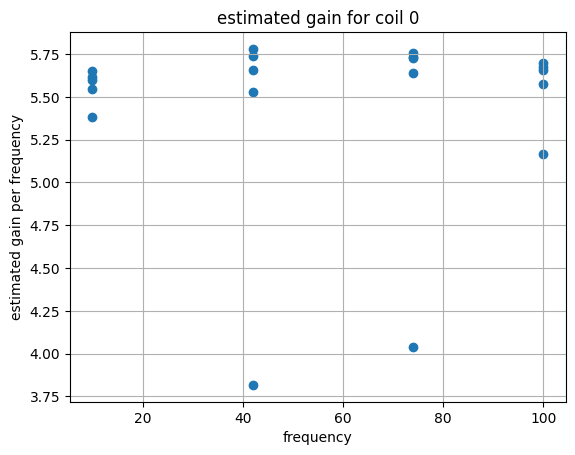

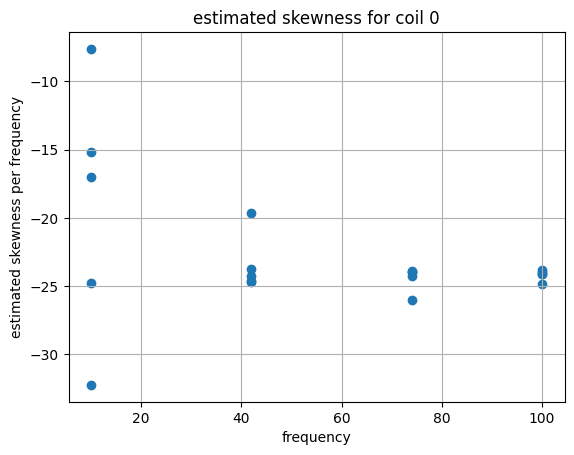

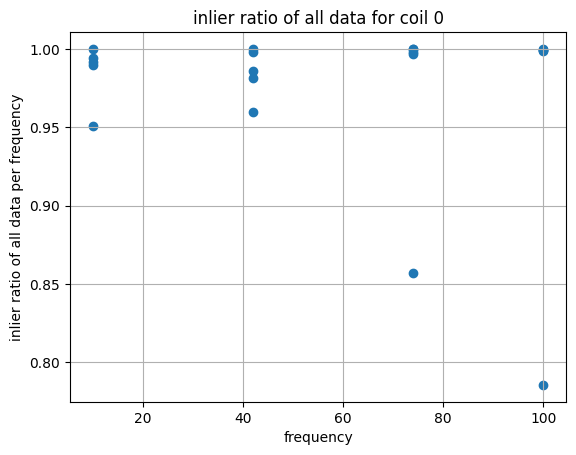

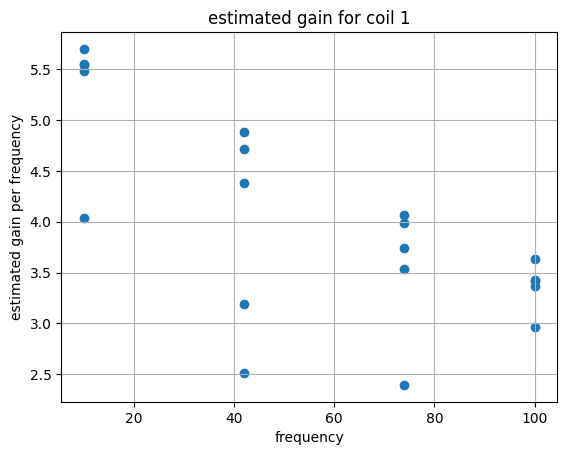

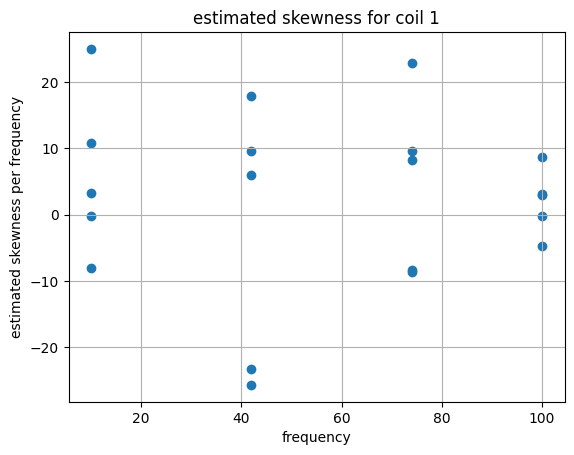

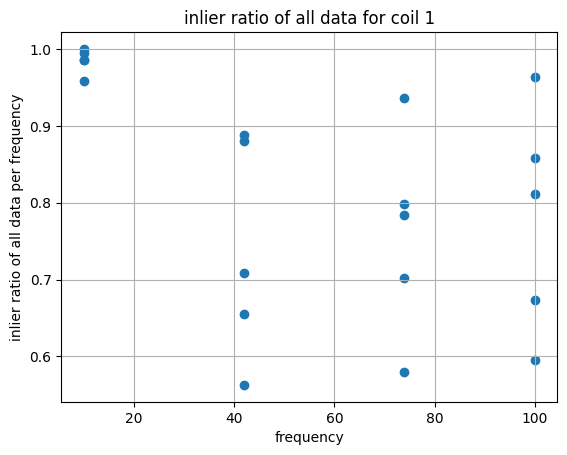

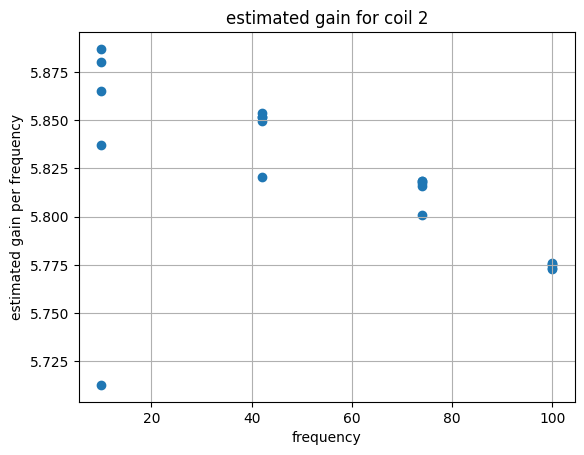

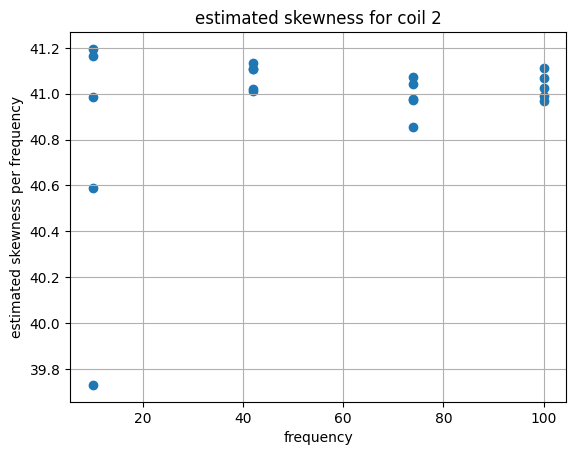

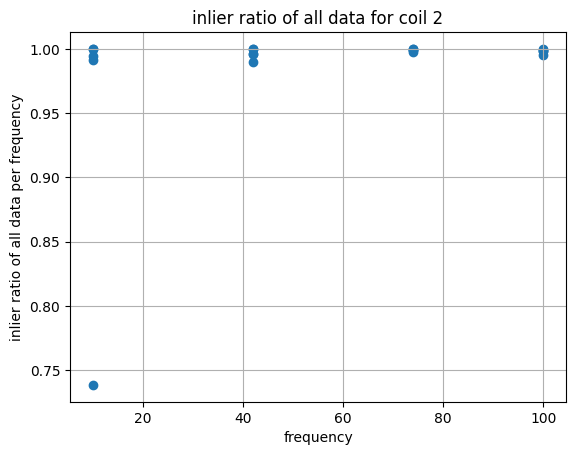

In [28]:
dataframe_save_gain_skewness=pd.DataFrame(save_gain_skewness)
for coil_index in range(3):
    condition=dataframe_save_gain_skewness["coil"]==coil_index
    filtered_dataframe=dataframe_save_gain_skewness[condition]
    plt.figure()
    plt.scatter(filtered_dataframe["frequency"],filtered_dataframe["estimated_gain"])
    plt.xlabel("frequency")
    plt.ylabel("estimated gain per frequency")
    plt.title("estimated gain for coil "+str(coil_index))
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.scatter(filtered_dataframe["frequency"],filtered_dataframe["estimated_skewness"])
    plt.xlabel("frequency")
    plt.ylabel("estimated skewness per frequency")
    plt.title("estimated skewness for coil "+str(coil_index))
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.scatter(filtered_dataframe["frequency"],filtered_dataframe["inlier_ratio"])
    plt.xlabel("frequency")
    plt.ylabel("inlier ratio of all data per frequency")
    plt.title("inlier ratio of all data for coil "+str(coil_index))
    plt.grid(True)
    plt.show()

This part gives a histogram of spread for the delays between the peaks of the current and magnetic signal. There is one histogram per peak, which makes a total of 2 histograms in one plot for all activated coils, all frequencies and all current amplitudes:

Text(0.5, 1.0, 'second peak per cycle')

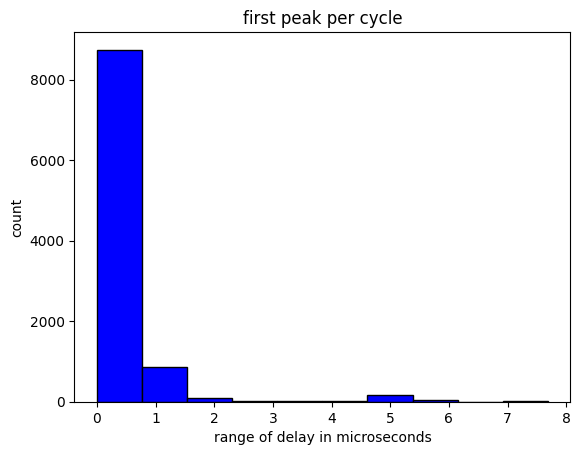

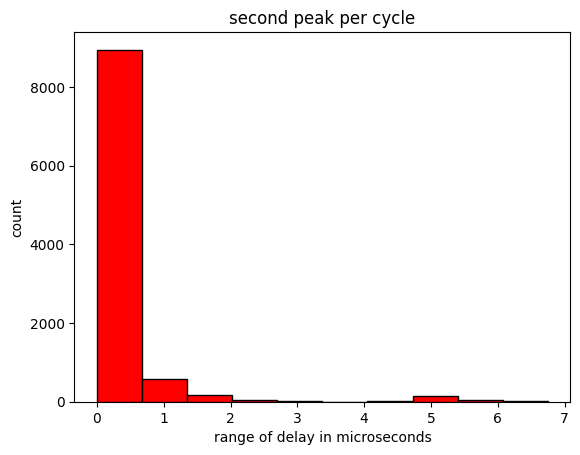

In [32]:
plt.figure()
plt.hist(np.abs(save_time_delay[1:,0])*1e+6/frequency_amplitude_data.timestamp_counts_per_second,bins=10, color='blue', edgecolor='black') 
plt.xlabel("range of delay in microseconds")
plt.ylabel("count")
plt.title("first peak per cycle")
plt.figure()
plt.hist(np.abs(save_time_delay[1:,1])*1e+6/frequency_amplitude_data.timestamp_counts_per_second,bins=10, color='red', edgecolor='black') 
plt.xlabel("range of delay in microseconds")
plt.ylabel("count")
plt.title("second peak per cycle")

And the next plot shows the system as a pure gain because the largest magnitude of the frequency response appears to be on zero frequency. However there are some much smaller gains for other frequencies which can come from high frequency noise components from the measurements.

<class 'dict'>


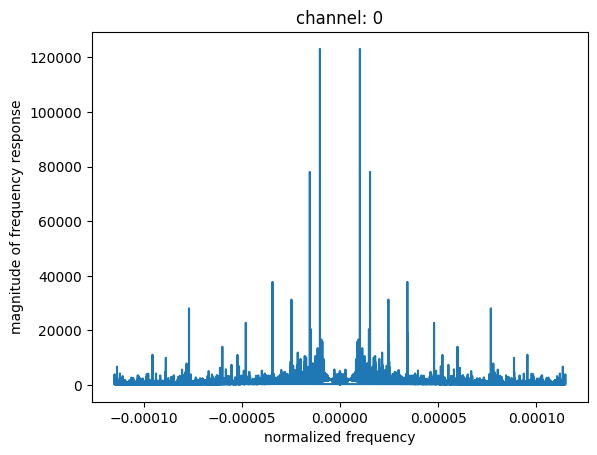

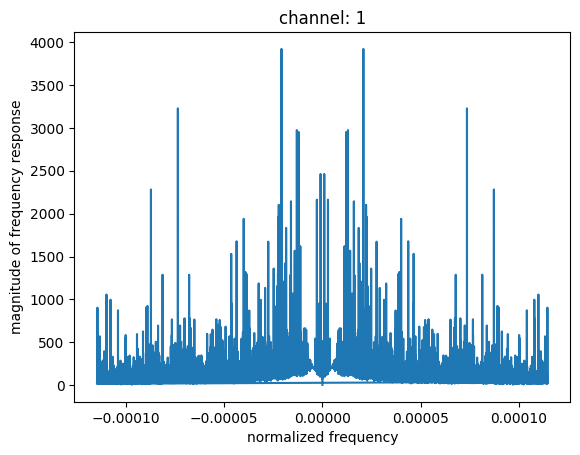

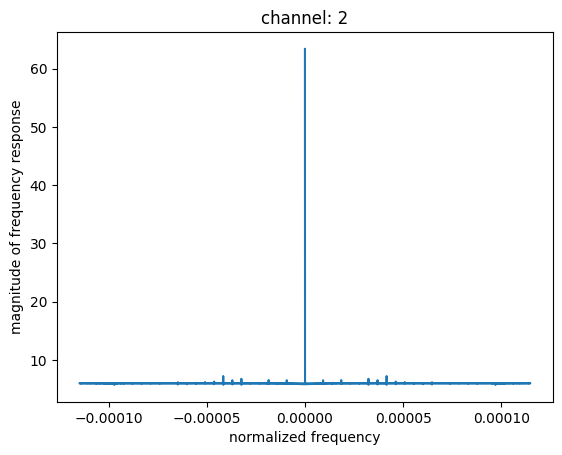

In [38]:
print(type(frequency_response_data[0]))
for channel in range(3):
    plt.figure()
    for item in frequency_response_data:
        if item["coil"]==channel:
            plt.plot(item["frequency_axis"],item["frequency_response"])
    plt.xlabel("normalized frequency")
    plt.ylabel("magnitude of frequency response")
    plt.title("channel: "+str(channel))
    plt.show()